In [25]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt

## A/B Testing
- Subjects (the thing exposed to treatment) are assigned to two groups that are treated exactly alike, except that the treatment under study differs from one group to another.
- Ideally, subjects are assigned randomly to these groups.


## Hypothesis Testing
- The null hypothesis embodies the notion that nothing significant has occurred, and any observed effect is due to random chance.
- Hypothesis testing assumes the null hypothesis is true, creates a probability model (the "null model"), and tests whether the observed effect is a reasonable outcome of that model.

## Resampling

### Permutation Test: web example

In [28]:
web_times = pd.read_csv('../../data/web_page_data.csv')
web_times['Time'] *= 100

In [36]:
print('# values from web A = ' + str(len(web_times[web_times.Page == 'Page A'])))
print('# values from web B = ' + str(len(web_times[web_times.Page == 'Page B'])))

# values from web A = 21
# values from web B = 15


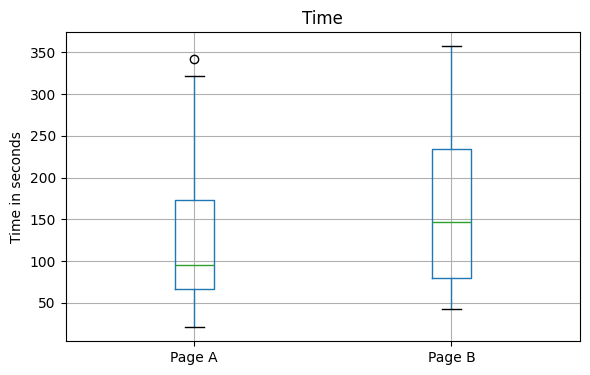

In [29]:
# We hypothesize that longer web page engagement leads to more sales. Our metric is average session time, comparing page A to page B.

ax = web_times.boxplot(by='Page', column='Time', figsize=(6,4))
ax.set_xlabel('')
ax.set_ylabel('Time in seconds')
plt.suptitle('')
plt.tight_layout()

In [31]:
mean_A = web_times[web_times['Page'] == 'Page A']['Time'].mean()
mean_B = web_times[web_times['Page'] == 'Page B']['Time'].mean()

print('Mean session times webpage A = ' + str(round(mean_A, 2)))
print('Mean session times webpage B = ' + str(mean_B))
print('Difference = ' + str(abs(round(mean_A-mean_B, 2))))

Mean session times webpage A = 126.33
Mean session times webpage B = 162.0
Difference = 35.67


Page B clearly leads to longer sessions than page A.  

Page B's session times are, on average, 35.67 seconds longer than Page A's. To determine if this difference is statistically significant or due to random chance, we can use a **permutation test**:  

- Combine all session times, shuffle them, and repeatedly divide them into two groups of 21 (Page A) and 15 (Page B). Then, compare the observed difference to the distribution of differences from the shuffled groups.

In [35]:
def perm_mean_diff(df, n_A, n_B, column):
    n = n_A + n_B
    new_A = resample(df, n_samples=n_A, replace=False)
    new_B = df.drop(new_A.index)
    return new_B[column].mean() - new_A[column].mean()

Text(0, 0.5, 'Frequency')

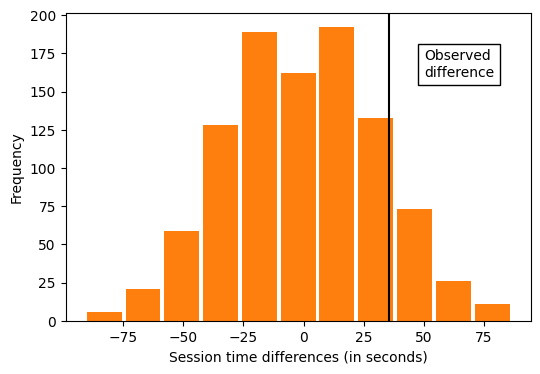

In [71]:
perm_diffs = [perm_mean_diff(web_times, 21, 15, 'Time') for _ in range(1000)]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(x=perm_diffs, bins=11, rwidth=0.9, color='C1')
ax.axvline(x = mean_B - mean_A, color='black', lw=1.5)
ax.text(50, 160, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

The mean difference of random permutations often exceeds the observed difference in session times (the vertical line).  
For our results, this happens in 13% of the cases:

In [74]:
np.mean(perm_diffs > mean_B - mean_A)

0.13

This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.  

### Permutation Tests: Key Takeaways for Data Science

Permutation tests are valuable for exploring random variation. They are easy to code, interpret, and explain, providing a practical alternative to formula-based statistics, which often imply unwarranted precision. Unlike traditional methods, permutation tests are versatile, handling numeric or binary data with equal or different sample sizes, without assuming normal distributions. This flexibility makes permutation tests a robust, one-size-fits-all approach to statistical inference.  

Comparing the observed value of the statistic to the resampled distribution allows you to judge whether an observed difference between samples might occur by chance.

## Significance Test: _p_-values

- Significance tests are used to determine whether an observed effect is within the range of chance variation for a null hypothesis model.
- The p-value is the probability that results as extreme as the observed results might occur, given a null hypothesis model.
- The alpha value is the threshold of “unusualness” in a null hypothesis chance model.
- Significance testing has been much more relevant for formal reporting of research than for data science (but has been fading recently, even for the former).


### E-commerce experiment example

In [2]:
ecomm_outcome = {
    'Price A': {
        'Conversion': 200, 'No conversion': 23539
    },
    'Price B': {
        'Conversion': 182, 'No conversion': 22406
    }
}

In [20]:
# We can test if the  difference in conversions between prices A and B is within the range of chancevariation, using a resampling procedure
# Null Hypothesis H0: there is no difference between the rates

converted_rate_A = ecomm_outcome['Price A']['Conversion'] / sum(ecomm_outcome['Price A'].values())
converted_rate_B = ecomm_outcome['Price B']['Conversion'] / sum(ecomm_outcome['Price B'].values())

obs_diff_pctg = round(100 * (converted_rate_A - converted_rate_B), 4)
obs_diff_pctg


0.0368

Text(0, 0.5, 'Frequency')

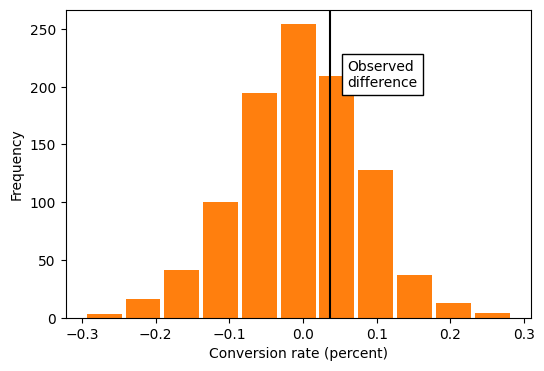

In [58]:
# rate B + 5% is approximately rate A, so:
# the following permutation tests asks: If the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?

# Put cards labeled 1 and 0 in a box
total_conversions = ecomm_outcome['Price A']['Conversion'] + ecomm_outcome['Price B']['Conversion']
total_no_conversions = ecomm_outcome['Price A']['No conversion'] + ecomm_outcome['Price B']['No conversion']
conversion = [1] * total_conversions + [0] * total_no_conversions

conversion = pd.DataFrame({'Results': conversion})

n_A = sum(ecomm_outcome['Price A'].values())
n_B = sum(ecomm_outcome['Price B'].values())


# Shuffle and draw out a resample of size 23,739 (same n as price A), and record how many 1s.
# Record the number of 1s in the remaining 22,588 (same n as price B). a 1000 times

perm_diffs = [100 * perm_mean_diff(conversion, n_A, n_B, 'Results') for _ in range(1000)]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(x=perm_diffs, bins=11, rwidth=0.9, color='C1')
ax.axvline(x=obs_diff_pctg, color='black', lw=1.5)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')


# How often was the difference >= 0.0368?


In [59]:
# We estimate the p-value from our permutation test by determining the frequency with which the chance model yields a result more extreme than the observed result.
# This is calculated as the proportion of times the permutation test generates a difference equal to or greater than the observed difference.

np.mean([diff >= obs_diff_pctg for diff in perm_diffs])

0.302

The p-value is 0.302, which means that we would expect to achieve a result more extreme than the observed by random chance over 30% of the time.  

Taking a 0.05 threshold value (_alpha_), our _p_-value was greater, and we cannot reject the null hypothesis. This means that the observed difference in your ecommerce experiment is not statistically significant, and it could have occurred by chance. 